<a href="https://colab.research.google.com/github/mvbaracho/DataMinning/blob/main/Deteccao_Anomalia/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#BIBLIOTECAS

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns
import statistics
import datetime as dt
import calendar
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn import preprocessing

%matplotlib inline
# IMPORTAÇÃO DB


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"138bRT5WPXfCdZj2fS_sMars4NlaQr75y"})
downloaded.GetContentFile('Sales2.csv')

# Carregamento da Base de dados

In [ ]:
# CARREGANDO DB
df = pd.read_csv('Sales2.csv', sep=';', na_values='?')
df.head()

,Retailer,Pdv,Price,PaymentMethod,Timestamp,City,State
0,536329,137,0.15,1,2018-05-16 17:30:23.000,Pereira Barreto,SP
1,536329,136,1.38,1,2018-05-17 10:21:36.000,Pereira Barreto,SP
2,536329,135,1.00,1,2018-05-17 10:23:59.000,Pereira Barreto,SP
3,536329,135,10.00,1,2018-05-17 10:29:24.000,Pereira Barreto,SP
4,536329,136,0.79,1,2018-05-17 10:32:20.000,Pereira Barreto,SP


## Pré-processamento

In [ ]:
# Trata a coluna Timestamp e insere a coluna Weekday necessária para realizar os próximos cálculos
df['Timestamp']= pd.to_datetime(df['Timestamp'],format='%Y-%m-%d')
df['Weekday'] = df['Timestamp'].dt.day_name()
df

,Retailer,Pdv,Price,PaymentMethod,Timestamp,City,State,Weekday
0,536329,137,0.15,1,2018-05-16 17:30:23,Pereira Barreto,SP,Wednesday
1,536329,136,1.38,1,2018-05-17 10:21:36,Pereira Barreto,SP,Thursday
2,536329,135,1.00,1,2018-05-17 10:23:59,Pereira Barreto,SP,Thursday
3,536329,135,10.00,1,2018-05-17 10:29:24,Pereira Barreto,SP,Thursday
4,536329,136,0.79,1,2018-05-17 10:32:20,Pereira Barreto,SP,Thursday
...,...,...,...,...,...,...,...,...
1801730,536573,133,0.91,1,2021-07-15 09:36:07,Ilha Solteira,SP,Thursday
1801731,548680,2261,9.54,8,2021-07-15 09:36:30,Fernandópolis,SP,Thursday
1801732,536330,134,9.74,8,2021-07-15 09:36:45,São José do Rio Preto,SP,Thursday
1801733,545741,136,9.46,8,2021-07-15 09:36:49,Pereira Barreto,SP,Thursday


In [ ]:
#Calcula a quantidade de cada dia da semana na base 
start = df['Timestamp'].min().strftime('%Y-%m-%d')
end = df['Timestamp'].max().strftime('%Y-%m-%d')
weekday = ['Sat', 'Fri', 'Tue', 'Mon', 'Thu', 'Wed', 'Sun']

qnt_weekday = []
for elem in weekday:
  qtd = np.busday_count(start, end, weekmask=elem)
  qnt_weekday.append((elem,qtd))

qnt_weekday

[('Sat', 165),
 ('Fri', 165),
 ('Tue', 165),
 ('Mon', 165),
 ('Thu', 165),
 ('Wed', 166),
 ('Sun', 165)]

In [ ]:
#Calcula a média total de vendas de acordo com o dia da semana, retornando uma lista de tuplas com o dia da semana e sua média de vendas
weekday_rec = df['Weekday'].value_counts()
weekday_mean = []
weekday_values = []
for elem in weekday_rec:
  weekday_values.append(elem)

i = 0
for elem, value in qnt_weekday:
    weekday_mean.append((elem,round(weekday_values[i]/value)))
    i += 1
weekday_mean

[('Sat', 2007),
 ('Fri', 1746),
 ('Tue', 1667),
 ('Mon', 1638),
 ('Thu', 1618),
 ('Wed', 1591),
 ('Sun', 643)]

In [ ]:
# Pré-processamento: obtém a coluna Price(Somatório das vendas do dia) e insere a coluna Weekday
df_class2 = df[['Timestamp', 'Price']].groupby(pd.Grouper(key='Timestamp', freq='1D')).sum()['Price']
# A partir daqui, um novo dataframe será gerado(df2) para trabalharmos
df2 = pd.DataFrame(df_class2)
# Tratamento para que a coluna Timestamp seja criada(o index está como Timestamp, por isso a necessidade dessa atribuição)
df2['Timestamp'] = df2.index
# Necessário dropar o index Timestamp para que o index seja resetado para inteiros
df2 = df2.reset_index(drop=True)
# Coluna Weekday inserida novamente de acordo com os novos Timestamps
df2['Weekday'] = df2['Timestamp'].dt.day_name()
df2 = df2.rename(columns={'Price':'Amount'})
df2 

,Amount,Timestamp,Weekday
0,0.15,2018-05-16,Wednesday
1,156.34,2018-05-17,Thursday
2,370.60,2018-05-18,Friday
3,239.73,2018-05-19,Saturday
4,118.32,2018-05-20,Sunday
...,...,...,...
1152,1814.46,2021-07-11,Sunday
1153,4651.45,2021-07-12,Monday
1154,4578.15,2021-07-13,Tuesday
1155,4059.69,2021-07-14,Wednesday


In [ ]:
# Pré-processamento -> LabelEncoder para transformar strings para inteiros
le = preprocessing.LabelEncoder()
df2['Weekday'] = le.fit_transform(df2['Weekday'])
df2

,Amount,Timestamp,Weekday
0,0.15,2018-05-16,6
1,156.34,2018-05-17,4
2,370.60,2018-05-18,0
3,239.73,2018-05-19,2
4,118.32,2018-05-20,3
...,...,...,...
1152,1814.46,2021-07-11,3
1153,4651.45,2021-07-12,1
1154,4578.15,2021-07-13,5
1155,4059.69,2021-07-14,6


In [ ]:
#Dicionário criado para associar o dia ao seu valor do DataFrame
dc = {'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3,'Thu': 4,
 'Fri': 5,
 'Sat': 6}
x = []
# Itera sobre o a lista weekday_mean para associar o valor do dia da semana(0 a 6) com a média de vendas desse dia. ex: 0: 643(Domingo);  6: 2007(Sábbado)
for elem in weekday_mean:
   x.append((dc[elem[0]],elem[1]))
  
#transforma x num dicionário
x = dict(x)

In [ ]:
# Obtém 2 arrays:   array z -> obtém todos os Prices(Amount)  array y -> obtém todos os dias (0 a 6)
z, y = df2.values[:, 0], df2.values[:, -1]
analysis = []
for i in range(len(z)):
    if z[i] >= x[y[i]]:
      analysis.append('Good') 
    else:
      analysis.append('Bad')
#atribui a lista gerada para uma nova coluna(Analysis)
df2['Analysis'] = analysis
df2

,Amount,Timestamp,Weekday,Analysis
0,0.15,2018-05-16,6,Bad
1,156.34,2018-05-17,4,Bad
2,370.60,2018-05-18,0,Bad
3,239.73,2018-05-19,2,Bad
4,118.32,2018-05-20,3,Bad
...,...,...,...,...
1152,1814.46,2021-07-11,3,Good
1153,4651.45,2021-07-12,1,Good
1154,4578.15,2021-07-13,5,Good
1155,4059.69,2021-07-14,6,Good


In [ ]:
df2['Analysis'] = le.fit_transform(df2['Analysis'])
df2

,Amount,Timestamp,Weekday,Analysis
0,0.15,2018-05-16,6,0
1,156.34,2018-05-17,4,0
2,370.60,2018-05-18,0,0
3,239.73,2018-05-19,2,0
4,118.32,2018-05-20,3,0
...,...,...,...,...
1152,1814.46,2021-07-11,3,1
1153,4651.45,2021-07-12,1,1
1154,4578.15,2021-07-13,5,1
1155,4059.69,2021-07-14,6,1


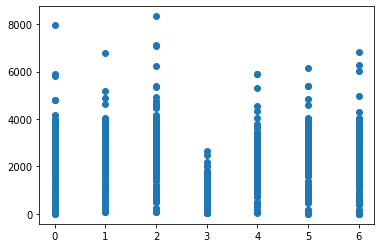

In [ ]:
plt.scatter(df2['Weekday'],df2['Amount'])
plt.show()

(array([155., 202., 307., 322., 129.,  22.,   7.,   7.,   4.,   2.]),
 array([   0.   ,  833.032, 1666.064, 2499.096, 3332.128, 4165.16 ,
        4998.192, 5831.224, 6664.256, 7497.288, 8330.32 ]),
 <a list of 10 Patch objects>)

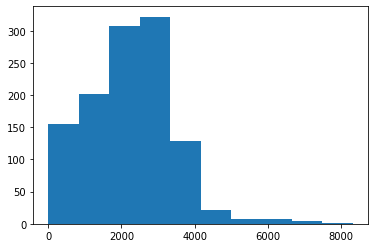

In [ ]:
plt.hist(df2['Amount'])

##**Isolation Forest**

In [ ]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Normalização dos dados
#x = (x-x.min())/(x.max()-x.min())
scaler = MinMaxScaler()
df3 = df2.drop(columns=['Timestamp'])
data = scaler.fit_transform(df3)

In [ ]:
#Isolation Forest with Analysis column
iso = IsolationForest(contamination=0.05)
y_pred = iso.fit_predict(data)
y_pred

array([-1,  1, -1, ...,  1,  1,  1])

In [ ]:
df2['IsOutlier'] = y_pred
df2

,Amount,Timestamp,Weekday,Analysis,IsOutlier
0,0.15,2018-05-16,6,0,-1
1,156.34,2018-05-17,4,0,1
2,370.60,2018-05-18,0,0,-1
3,239.73,2018-05-19,2,0,1
4,118.32,2018-05-20,3,0,1
...,...,...,...,...,...
1152,1814.46,2021-07-11,3,1,1
1153,4651.45,2021-07-12,1,1,1
1154,4578.15,2021-07-13,5,1,1
1155,4059.69,2021-07-14,6,1,1


In [ ]:
# Returns the number of outliers
def qtyOutliers(y_pred):
  c= 0
  for item in y_pred:
    if item == -1:
      c+=1
  return c
qtyOutliers(y_pred)

58

## **Isolation Forest - Teste 2**

In [ ]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Normalização dos dados
#x = (x-x.min())/(x.max()-x.min())
scaler = MinMaxScaler()
df3 = df2.drop(columns=['Timestamp','Analysis'])
data2 = scaler.fit_transform(df3)

In [ ]:
#Isolation Forest without Analysis column
iso = IsolationForest(contamination=0.05)
y_pred2 = iso.fit_predict(data2)
y_pred2

array([-1,  1, -1, ...,  1,  1,  1])

In [ ]:
df3['IsOutlier'] = y_pred2
df3

,Amount,Weekday,IsOutlier
0,0.15,6,-1
1,156.34,4,1
2,370.60,0,-1
3,239.73,2,1
4,118.32,3,1
...,...,...,...
1152,1814.46,3,1
1153,4651.45,1,1
1154,4578.15,5,1
1155,4059.69,6,1


In [ ]:
qtyOutliers(y_pred)

58

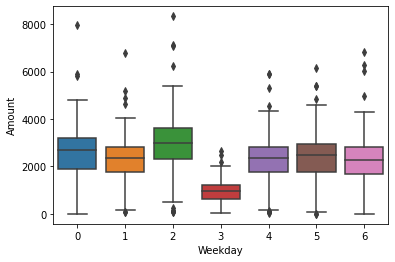

In [ ]:
sns.boxplot(x='Weekday', y='Amount', data=df2)

##**Local Outlier Factor**

In [ ]:
# evaluate model performance with outliers removed using local outlier factor
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error

In [ ]:
lof = LocalOutlierFactor(contamination=0.05)
ypred3 = lof.fit_predict(data)
# select all rows that are not outliers

In [ ]:
ypred3

array([ 1,  1,  1, ..., -1, -1,  1])

In [ ]:
df2['IsOutlier'] = ypred3
df2

,Amount,Timestamp,Weekday,Analysis,IsOutlier
0,0.15,2018-05-16,6,0,1
1,156.34,2018-05-17,4,0,1
2,370.60,2018-05-18,0,0,1
3,239.73,2018-05-19,2,0,1
4,118.32,2018-05-20,3,0,1
...,...,...,...,...,...
1152,1814.46,2021-07-11,3,1,-1
1153,4651.45,2021-07-12,1,1,-1
1154,4578.15,2021-07-13,5,1,-1
1155,4059.69,2021-07-14,6,1,-1


In [ ]:
qtyOutliers(ypred3)

58